In [1]:
library(ggplot2)
library(gdata)
library(stringr)
library(RColorBrewer)
options(sqldf.driver = "SQLite") # as per FAQ #7 force SQLite
options(gsubfn.engine = "R")
library(sqldf)
library(scales)
library(reshape2)
library(Hmisc)
library(readr)
library(tidyr)
library(dplyr)
library(forcats)
library(gridExtra)

#mass = read_csv("results/20181218_151403/20181218_151403.csv")

mass = read_csv("results/latest/all.csv")
describe(mass$Number_Partitions)

gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.

Attaching package: ‘gdata’

The following object is masked from ‘package:stats’:

    nobs

The following object is masked from ‘package:utils’:

    object.size

The following object is masked from ‘package:base’:

    startsWith

Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite
Loading required package: lattice
Loading required package: survival
Loading required package: Formula

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, units


Attaching package: ‘readr’

The following object is masked from ‘package:scales’:

    col_factor


Attaching package: ‘tidyr’

The following object is masked from ‘package:reshape2’:

    smiths


Attaching package: ‘dplyr’

The following objects are masked from ‘package:Hmisc’:

    src, summarize

The following objects ar

mass$Number_Partitions 
       n  missing distinct     Info     Mean      Gmd 
     437        0        5    0.957    109.9    95.05 
                                        
Value         16    32    64   128   256
Frequency     65    78    91   104    99
Proportion 0.149 0.178 0.208 0.238 0.227

In [2]:
summary(mass)

 Application        Number_Clusters Number_Points_per_Cluster   Number_Dim
 Length:437         Min.   :-1      Min.   :-1                Min.   :-1  
 Class :character   1st Qu.:-1      1st Qu.:-1                1st Qu.:-1  
 Mode  :character   Median :-1      Median :-1                Median :-1  
                    Mean   :-1      Mean   :-1                Mean   :-1  
                    3rd Qu.:-1      3rd Qu.:-1                3rd Qu.:-1  
                    Max.   :-1      Max.   :-1                Max.   :-1  
 Number_Points_per_Message Bytes_per_Message Number_Messages    Interval
 Min.   :-1                Min.   :1024      Min.   :48      Min.   :0  
 1st Qu.:-1                1st Qu.:1024      1st Qu.:48      1st Qu.:0  
 Median :-1                Median :1024      Median :48      Median :0  
 Mean   :-1                Mean   :1024      Mean   :48      Mean   :0  
 3rd Qu.:-1                3rd Qu.:1024      3rd Qu.:48      3rd Qu.:0  
 Max.   :-1                Max.   :10

In [6]:
describe(mass$Application)

mass$Application 
        n   missing  distinct     value 
      175         0         1 synthetic 
                    
Value      synthetic
Frequency        175
Proportion         1

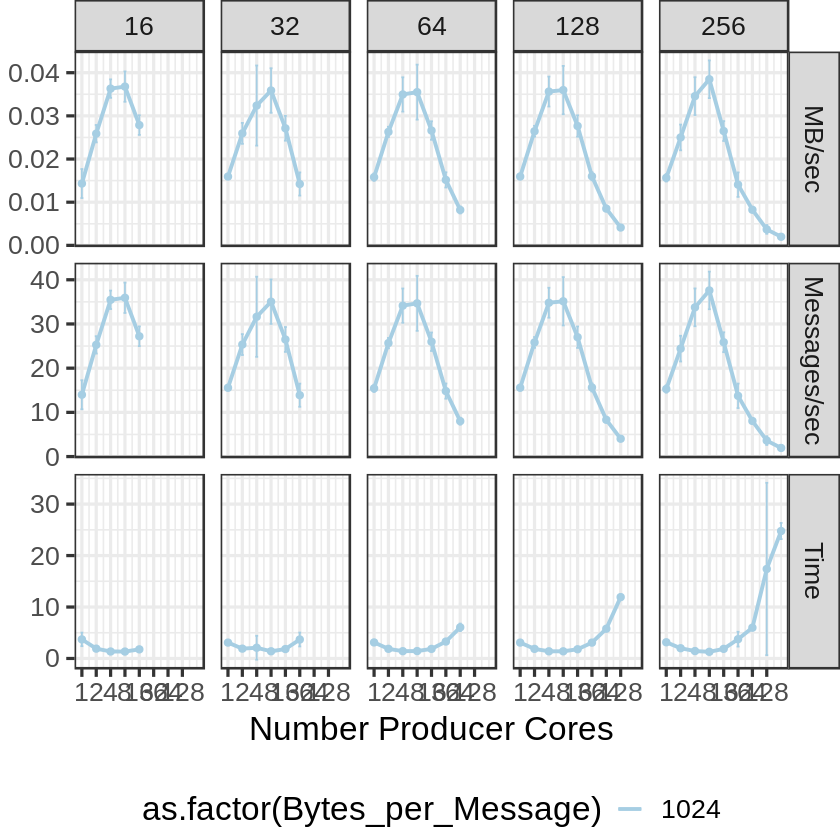

In [4]:

#mass_filtered <-mass %>% filter(Bytes_per_Message<400000 & Number_Points_per_Message ==5000)

mass_long = mass %>% drop_na(Time) 

mass_long = mass %>% drop_na() %>%
  mutate(Bytes_per_sec = Records_per_sec*Bytes_per_Message)%>%
  mutate(MBytes_per_sec = Bytes_per_sec/1000000,
         Broker_Scenario = paste(Number_Brokers, "Broker(s)"))%>%
  mutate(Scenario = paste(Application, "-", Number_Points_per_Message, sep=""))%>%
  #filter(Number_Points_per_Message!=10000 & Number_Points_per_Message!=20000)%>%
  select(c(Application, Scenario, Broker_Scenario, Number_Points_per_Message, Number_Processes, 
           Number_Brokers, Number_Partitions, Number_Messages, Bytes_per_Message, Time, Points_per_sec,Records_per_sec,
           Bytes_per_sec,MBytes_per_sec)) %>%
  gather(type, value, c(Records_per_sec, MBytes_per_sec, Time)) %>%
  mutate(type = fct_recode(as.factor(type), 
                           "Messages/sec" = "Records_per_sec" , 
                           "MB/sec" = "MBytes_per_sec"  )) # %>% 
 # mutate(Application = fct_recode(as.factor(Application), 
 #                                 "KMeans-Random" = "kmeans" , 
 #                                 "Lightsource-static" = "light",
 #                                 "KMeans-Static" = "kmeansstatic"
 #                                 )) 



pp <- ggplot(mass_long, aes(x=Number_Processes, y=value, color=as.factor(Bytes_per_Message), fill=Application)) +
  geom_line(stat="summary", fun.y="mean",  size=1.1) + geom_point(stat="summary", fun.y="mean", size=1.7, show.legend = F) +
  stat_summary(fun.data = "mean_sdl", geom = "errorbar", fun.args = list(mult=1), width=.2) + 
  #geom_bar(stat="summary", fun.y="mean",  size=1.05, position = position_dodge()) + #geom_point(stat="summary", fun.y="mean", size=1.7, show.legend = F) +
  facet_grid(type~Number_Partitions,  scales = "free_y", space = "fixed")+
  #geom_errorbar(mapping=aes(ymin=mean-stddev, ymax=mean+stddev), width=0.2, size=0.6, position = position_dodge(width = 0.90), color="black") +
  scale_fill_brewer(palette="Paired")+ scale_color_brewer(palette="Paired")+ 
  theme_bw(base_size = 20) + theme(legend.position = "bottom", plot.margin=grid::unit(c(0,0,0,-6), "mm")) + 
  #theme(axis.text.x = element_text(angle=45, hjust=1)) +
  scale_x_continuous(trans=log2_trans(), breaks=c(1,2,4,8,16,32,64,128))+ 
  #scale_y_continuous(trans=log2_trans())+   
  #scale_y_log10(breaks=c(1,10,100,200, 500))+   
  xlab("Number Producer Cores") + 
  ylab("") +
  guides(fill=guide_legend(reverse=FALSE, ncol=5, keywidth=1)) +
  labs(fill = "Mini App Streaming Source:")
pp